# Regression Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Spain Electricity Shortfall Challenge

The government of Spain is considering an expansion of it's renewable energy resource infrastructure investments. As such, they require information on the trends and patterns of the countries renewable sources and fossil fuel energy generation. Your company has been awarded the contract to:

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of forecasting the three hourly demand shortfalls;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine what features were most important in the model’s prediction decision, and
- 7. explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model the shortfall between the energy generated by means of fossil fuels and various renewable sources - for the country of Spain. The daily shortfall, which will be referred to as the target variable, will be modelled as a function of various city-specific weather features such as `pressure`, `wind speed`, `humidity`, etc. As with all data science projects, the provided features are rarely adequate predictors of the target variable. As such, you are required to perform feature engineering to ensure that you will be able to accurately model Spain's three hourly shortfalls.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [58]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Libraries for data preparation and model building
from sklearn.feature_extraction.text import CountVectorizer

# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [59]:
# load the data
df = pd.read_csv('../resources/data/train.csv')
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


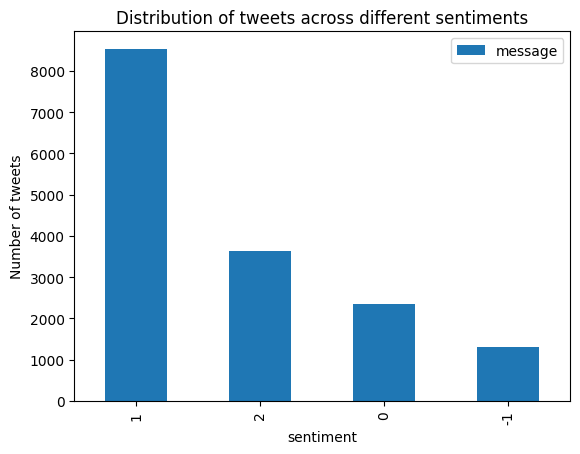

In [60]:
countv= df[['sentiment', 'message']].groupby('sentiment').count()
countv.sort_values('message', ascending=False).plot(kind='bar')
plt.title('Distribution of tweets across different sentiments')
plt.ylabel('Number of tweets')
plt.show()

DISTRIBUTION OF WORDS COUNTS ACROSS DIFFERENT SENTIMENTS

<Axes: ylabel='Density'>

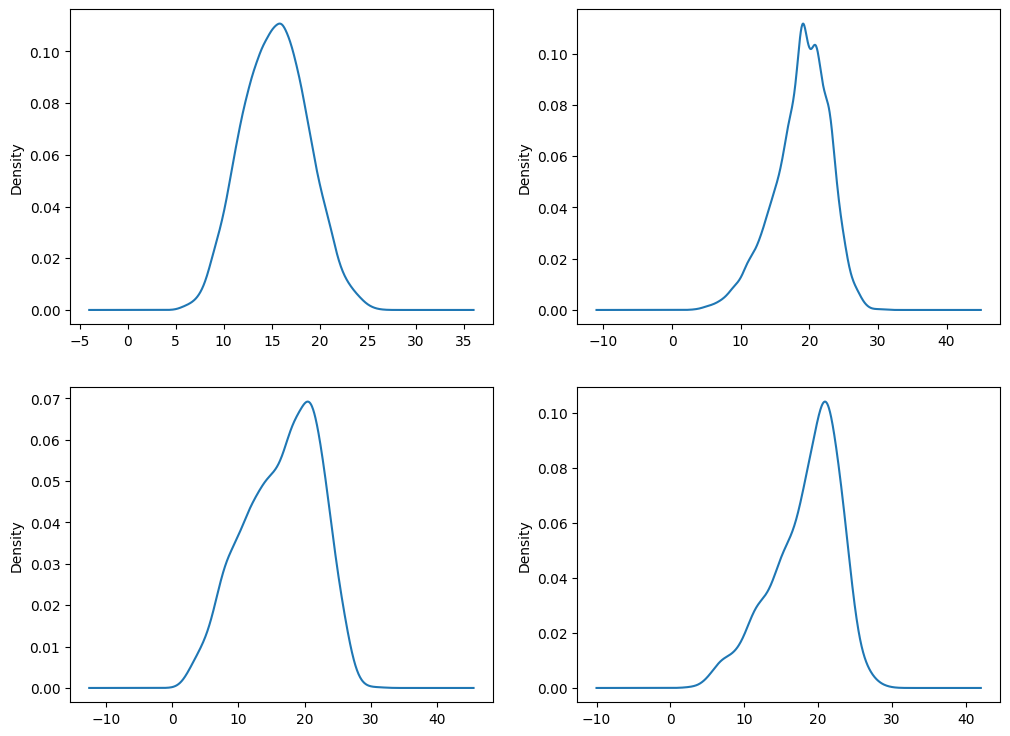

In [61]:
df['count']=df['message'].str.split().str.len()
Pro=df[df['sentiment']==1]
News=df[df['sentiment']==2]
Neutral=df[df['sentiment']==0]
Anti=df[df['sentiment']==-1]

fig, ax = plt.subplots(2, 2, figsize=(12, 9))
News['count'].plot(kind='density', ax=ax[0,0], label='News')
Pro['count'].plot(kind='density', ax=ax[0,1], label='Pro')
Neutral['count'].plot(kind='density', ax=ax[1,0], label='Neutral')
Anti['count'].plot(kind='density', ax=ax[1,1], label='Anti')

Text(0.5, 1.0, 'Top 20 words of News Sentiment')

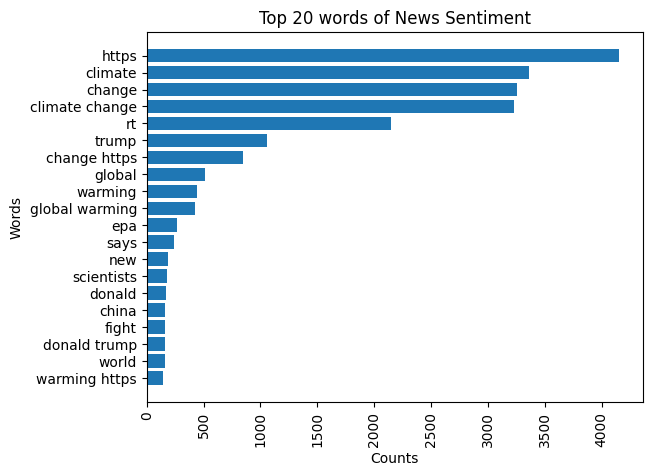

In [62]:
vect_news = CountVectorizer(lowercase=True, stop_words='english', max_features=20,analyzer='word', ngram_range=(1, 2))
News_fit=vect_news.fit_transform(News['message'].values.astype(str))
News_Names=vect_news.get_feature_names_out()
News_counts=News_fit.toarray().sum(axis=0)

#Sorting the values in ascending 
sorted_indices = News_counts.argsort()
sorted_words = [News_Names[i] for i in sorted_indices]
sorted_counts = News_counts[sorted_indices]

plt.barh(sorted_words, sorted_counts)
plt.xticks(rotation=90)
plt.xlabel('Counts')
plt.ylabel('Words')
plt.title('Top 20 words of News Sentiment')

Text(0.5, 1.0, 'Top 20 words of Anti Sentiment')

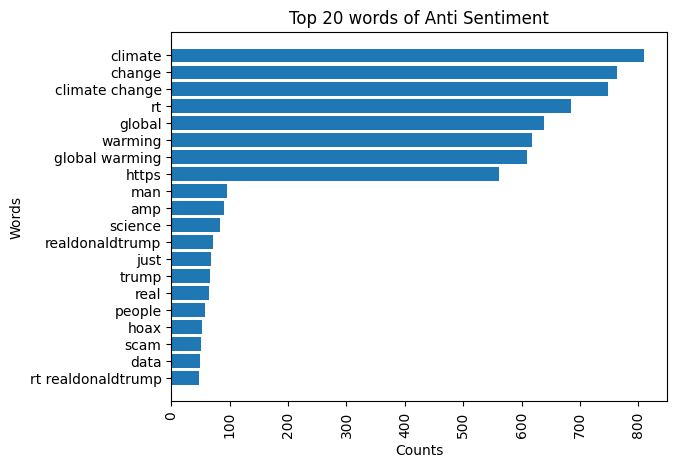

In [63]:

vect_Anti = CountVectorizer(lowercase=True, stop_words='english',  max_features=20, analyzer='word', ngram_range=(1, 2))
Anti_fit = vect_Anti.fit_transform(Anti['message'].values.astype(str))
Anti_Names=vect_Anti.get_feature_names_out()
Anti_counts=Anti_fit.toarray().sum(axis=0)

#Sorting the values in ascending 
sorted_indices = Anti_counts.argsort()
sorted_words = [Anti_Names[i] for i in sorted_indices]
sorted_counts = Anti_counts[sorted_indices]

#Ploting the bar plot of top 20 Anti Sentiment
plt.barh(sorted_words, sorted_counts)
plt.xticks(rotation=90)
#Labeling the x axis
plt.xlabel('Counts')
#Labeling the x axis
plt.ylabel('Words')
#The title
plt.title('Top 20 words of Anti Sentiment')

Text(0.5, 1.0, 'Top 20 words of Pro Sentiment')

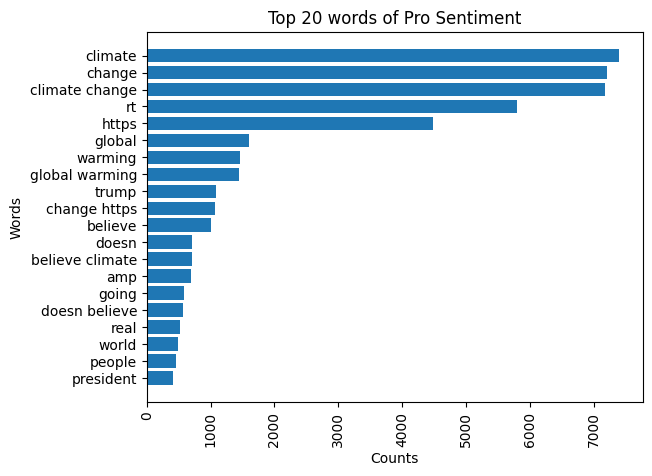

In [64]:
vect_Pro = CountVectorizer(lowercase=True, stop_words='english', max_features=20,analyzer='word', ngram_range=(1, 2))
Pro_fit = vect_Pro.fit_transform(Pro['message'].values.astype(str))
Pro_Names=vect_Pro.get_feature_names_out()
Pro_counts=Pro_fit.toarray().sum(axis=0)

#Sorting the values in ascending 
sorted_indices = Pro_counts.argsort()
sorted_words = [Pro_Names[i] for i in sorted_indices]
sorted_counts = Pro_counts[sorted_indices]

#Ploting the bar graph of the top 20 pro Sentiment
plt.barh(sorted_words, sorted_counts)
plt.xticks(rotation=90)
plt.xlabel('Counts')
plt.ylabel('Words')
plt.title('Top 20 words of Pro Sentiment')

Text(0.5, 1.0, 'Top 20 words of Neutral Sentiment')

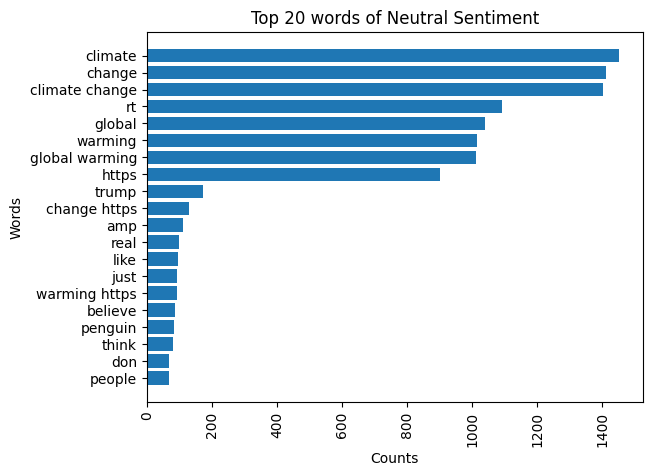

In [65]:
vect_Neutral = CountVectorizer(lowercase=True, stop_words='english', max_features=20,analyzer='word', ngram_range=(1, 2))
Neutral_fit=vect_Neutral.fit_transform(Neutral['message'].values.astype(str))
Neutral_Names=vect_Neutral.get_feature_names_out()
Neutral_counts=Neutral_fit.toarray().sum(axis=0)

#Sorting the values in ascending 
sorted_indices = Neutral_counts.argsort()
sorted_words = [Neutral_Names[i] for i in sorted_indices]
sorted_counts = Neutral_counts[sorted_indices]

plt.barh(sorted_words, sorted_counts)
plt.xticks(rotation=90)
plt.xlabel('Counts')
plt.ylabel('Words')
plt.title('Top 20 words of Neutral Sentiment')

In [66]:
# look at data statistics

In [67]:
# plot relevant feature interactions

In [68]:
# evaluate correlation

In [69]:
# have a look at feature distributions

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [70]:
# remove missing values/ features

In [71]:
# create new features

In [72]:
# engineer existing features

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [73]:
# split data

**Data Spliting:** The data was splited into 80% of training data and 20% testing data. Moveover, the random forest chosen for our project is 42.

In [ ]:
# split data
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.2, random_state=42)

**Names of all the models of choice**

In [ ]:
names = ['Logistic Regression', 'Nearest Neighbors',
         'RBF SVM',
         'Decision Tree', 'Random Forest']

**Building the Models:** There model of choice are Logistic regression, K Neighbors Classifiers, Support Vector Classifier, Decision Tree Classifier and Random Forest Classifier.

In [ ]:
classifiers = [
    LogisticRegression(C),
    KNeighborsClassifier(10),
    SVC(kernel="rbf", gamma=2, C=0.025),
    DecisionTreeClassifier(max_depth=3),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),

**Fitting the models, Predicting and examining the metrics**

In [74]:
results_train = []
results_test=[]

models = {}
confusion = {}
class_report = {}

for name, clf in zip(names, classifiers):

    #Fitting the models and recording the time
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    #Start time
    start_time = time.time()
    #Predicting on y_train using X_train
    y_pred = clf.predict(X_train)
    #End time
    end_time = time.time()
    #Execution Time
    train_execution_time = end_time - start_time

    #Start time
    start_time = time.time()
    #Predicting on y_train using X_train
    y_pred_test = clf.predict(X_test)
    #End time
    end_time = time.time()
    #Execution Time
    test_execution_time = end_time - start_time

    #Calculating the accuracy score of the training data
    accuracy_train = accuracy_score(y_train, y_pred)
    #Calculating the precision score of the training data
    precision_train = precision_score(y_train, y_pred, average='micro')
    #Calculating the recall score of the training data
    recall_train = recall_score(y_train, y_pred, average='micro')
    #Calculating the f1 score of the training data
    f1_train = f1_score(y_train, y_pred, average='micro')

    
    #Calculating the accuracy score of the testing data
    accuracy_test = accuracy_score(y_test, y_pred_test)
    #Calculating the precision score of the testing data
    precision_test = precision_score(y_test, y_pred_test, average='micro')
    #Calculating the recall score of the testing data
    recall_test = recall_score(y_test, y_pred_test, average='micro')
    #Calculating the F1 score of the testing data
    f1_test   = f1_score(y_test, y_pred_test, average='micro')

    # Save the results to dictionaries
    models[name]=clf
    #Confusion on the training data
    confusion[name] = confusion_matrix(y_train, y_pred)
    #Confusion on testing data
    confusion[name] = confusion_matrix(y_test, y_pred_test)
    #Classification report of the training data
    class_report[name] = classification_report(y_train, y_pred)
    #Classification report of the testing data
    class_report[name] = classification_report(y_test, y_pred_test)

    # Appending the name of the model, training data  results and fitting time of each model
    results_train.append([name, accuracy_train, precision_train, recall_train, f1_train, run_time.best, test_execution_time])
    # Appending the name of the model and  testing data  results
    results_test.append([name, accuracy_test, precision_test, recall_test, f1_test, train_execution_time])

#Converting the training results to a dataframe
results_train= pd.DataFrame(results_train, columns=['Classifier', 'Accuracy Train', 'Precision Train', 'Recall', 'F1 Train', 'Train Time', 'predicting time'])
results_train.set_index('Classifier', inplace= True)

#Converting the Testing data into a Dataframe
results_test= pd.DataFrame(results_test, columns=['Classifier', 'Accuracy Test', 'Precision  Test', 'Recall  Test', 'F1 Test', "Predicting time" ])
results_test.set_index('Classifier', inplace= True)


**DataFrame with different training data metric results**

In [ ]:
results_train

**DataFrame with different testing data metric results**

In [ ]:
results_test

In [75]:
# create one or more ML models

In [76]:
# evaluate one or more ML models

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [77]:
# Compare model performance

In [78]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [79]:
# discuss chosen methods logic